In [19]:
import time
import numpy as np
import pandas as pd
import xarray as xr
import xclim.indices as xci
from config import DOWNLOAD_DIR, INPUT_DIR, indices_fp
import luts
import indices as ic
# start timer
tic = time.perf_counter()

### Merge datasets, create daily sum of total precipitation

We need to merge the three (sometimes two?) datasets into a single dataframe.  Then, we need to produce total sums for each day.  Source data will contain a [mix of ERA5 and ERA5T data](https://confluence.ecmwf.int/display/CUSF/ERA5+CDS+requests+which+return+a+mixture+of+ERA5+and+ERA5T+data), so we need to do this to get a consistent set of data:
 
### Our algorithm for merging/fusing data needs to go like this,


 1. Some data files may not have `expver` present at all, such as older data which are outside the window of modification for the rolling ERA5 updates.  Use those data as-is.
 1. If `expver` has both values 1 and 5 (a mix of ERA5 and ERA5T data), choose `expver == 1` where possible, and `expver == 5` for timesteps when `expver == 1` is missing.
 1. For recent data, only `expver` value 5 is present.

#### Notes/Questions?

 * Current month may be only ERA5T / `expver = 5`
 * Prior months in the same year may have mix of `expver` 5 and 1.
 * Prior year doesn't have `expver`.


Needs to be robust to the presence/absence of expver.

Goal is that a dataframe taken for a single point looks correct with data for every timestep (no dupes, no missing).

## TODO: make this work properly for January when we may only have 2 data files.

Define a function to look for the three files for each variable in the input directory and make a complete file of the previous year's worth of data:

In [2]:
def assemble_dataset(input_dir, varname):
    varname_prefix = luts.varname_prefix_lu[varname]
    prior_year = xr.open_dataset(input_dir.joinpath(f"{varname_prefix}_previous_year.nc"))
    current_year = xr.open_dataset(input_dir.joinpath(f"{varname_prefix}_current_year.nc"))
    current_month = xr.open_dataset(input_dir.joinpath(f"{varname_prefix}_current_month.nc"))
    
    # Just want to make sure our assumption that data with expver values of 1 and 5 are
    #  mutually exclusive and exhaustive
    assert np.all(
        np.isnan(current_year[varname].sel(expver=5)) == ~np.isnan(current_year[varname].sel(expver=1))
    )
    assert np.all(
        ~np.isnan(current_year[varname].sel(expver=5)) == np.isnan(current_year[varname].sel(expver=1))
    )
    
    # Select the data for each expver value and combine to get a complete continuous set of data:
    current_year_fix = xr.merge([
        current_year[varname].sel(expver=1).drop("expver"),
        current_year[varname].sel(expver=5).drop("expver")
    ])
    assert ~np.any(np.isnan(current_year_fix[varname]).values)
    
    # merge with other dataset since they all share the same coordinate variables now
    hourly_ds = xr.merge([
        prior_year,
        current_year_fix,
        current_month,
    ])
    # resample ohurly to daily
    if varname in ["tp", "pev"]:
        # total precip should be summed
        daily_ds = hourly_ds.resample(time="1D").sum()
    elif varname in ["sd", "swvl1", "swvl2"]:
        # TO DO : check how the daily values of these variables should be calculated from hourly
        daily_ds = hourly_ds.resample(time="1D").mean()
        
    
        
    return daily_ds

Derive the yearly datasets from the downloads and combine into a single xarray dataset:

In [3]:
input_dir = DOWNLOAD_DIR.joinpath("inputs")

ds = xr.combine_by_coords(
    [assemble_dataset(input_dir, varname) for varname in ["tp", "sd", "pev"]], 
    combine_attrs="drop_conflicts"
)

So we really will only want data as far back as 1 year from most recent data we have (right?), so we can filter those days out:

In [4]:
end_time = ds.time[-1]
start_time = ds.time[-365]
# ensure that this is indeed 365 days (time diff is nanoseconds)
assert (end_time - start_time) / 86400E9
ds = ds.sel(time=slice(start_time, end_time))

Now we have a single dataset consisting of all* downloaded variables for deriving all* of the indices.

*(not really all of them yet)

## Indices

I know we have another notebook for processing these but we might consider just doing the preprocessing and processing in one go because the preprocessing is rather quick.

We will compute the following indices:

* SPI - standardized precipitation index
* SPEI (can ERA 5 do this?) – standardized potential evaporation index
* Total Precip
* % of Normal Precipitation
* SWE - snow water equivalent
* SWE % of Normal 
* Soil Moisture Deficit

These indices will be computed for the following time periods:

* 30 day
* 60 day
* 90 day
* 180 day
* 365 day

We may want to have the 5 time intervals for repeated use:

In [5]:
intervals = [30, 60, 90, 180, 365]
# also will be referencing the timestamps fairly often
times = ds.time.values

Define a function to query the climatology datasets consistently given the possibility of start/end dates for subsetting straddling the new year. E.g., if start DOY is before end DOY of interval period, then typical slice-based selection is fine. But if end DOY is before (less than) start DOY, e.g. looking back 30 days from Jan 5th, we need to do two selections:

In [6]:
def subset_clim_interval(clim_ds, start_doy, end_doy):
    if start_doy < end_doy:
        sub_ds = clim_ds.sel(time=slice(start_doy, end_doy))
    else:
        sub_ds = xr.merge([
            clim_ds.sel(time=slice(0, end_doy)),
            clim_ds.sel(time=slice(start_doy, 366))
        ])
        
    return sub_ds

Also create a dict for writing results maybe?

In [7]:
indices = {}

### Total precip

This one should be easy? Just sum over each time interval?

In [8]:
index = "tp"
indices[index] = {}
for i in intervals:
    indices[index][i] = ds[index].sel(
        time=slice(times[-(i)], times[-1])
    # convert from m to cm to match climatology
    ).sum(dim="time") * 100

###  Total Precip % of Normal

So now this one should calculate the percent of the climatologies that the above total precip values represent over the same time windows.

In [9]:
index = "pntp"
indices[index] = {}
with xr.open_dataset(INPUT_DIR.joinpath("era5_daily_tp_climatology_1981_2020_leap.nc")) as tp_clim_ds:
    # need to remap longitude coordinates from [180, 360] to [-180, 0]
    tp_clim_ds = tp_clim_ds.assign_coords(longitude=(tp_clim_ds.longitude.values) - 360)
    for i in intervals:
        start_doy = pd.Timestamp(times[-i]).dayofyear
        end_doy = pd.Timestamp(times[-1]).dayofyear
        clim_tp = subset_clim_interval(tp_clim_ds, start_doy, end_doy).sum(dim="time")
        indices[index][i] = np.round((indices["tp"][i] / clim_tp["tp"]) * 100, 1)
        indices[index][i].name = index

### Snow water equivalent (SWE)

#### TO:DO confirm aggregation method over the intervals (currently mean but this is just a guess)

In [10]:
index = "swe"

indices[index] = {}
for i in intervals:
    indices[index][i] = ds["sd"].sel(
        time=slice(times[-(i)], times[-1])
    ).mean(dim="time")
    indices[index][i].name = index

### SWE % of Normal

So now this one should calculate the percent of the climatologies that the above total precip values represent over the same time windows.

In [11]:
index = "pnswe"
indices[index] = {}
with xr.open_dataset(INPUT_DIR.joinpath("era5_swe_climo_81-20.nc")) as swe_clim_ds:
    # need to remap longitude coordinates from [180, 360] to [-180, 0]
    swe_clim_ds = swe_clim_ds.assign_coords(
        longitude=(swe_clim_ds.longitude.values) - 360,
        # just convert time dim to DOY days for consistency with tp
        time=np.arange(swe_clim_ds.time.shape[0]) + 1
    )
    for i in intervals:
        start_doy = pd.Timestamp(times[-i]).dayofyear
        end_doy = pd.Timestamp(times[-1]).dayofyear
        clim_swe = subset_clim_interval(swe_clim_ds, start_doy, end_doy).mean(dim="time")
        indices[index][i] = (indices["swe"][i] / clim_swe["swe"]) * 100
        # over the water, SWE will always be zero. This comes out as NaN in the results (the only NaNs)
        #  For now just treat this area as 100% of normal.
        indices[index][i].values[np.isnan(indices[index][i])] = 100
        indices[index][i].name = index

### SPI

Standardized Precipitation Index.

In [12]:
index = "spi"
indices[index] = {}
with xr.open_dataset(INPUT_DIR.joinpath("spi_gamma_parameters.nc")) as spi_ds:
    for i in intervals:
        indices[index][i] = ic.spi(ds["tp"], spi_ds["params"], i)
        indices[index][i].name = index

### SPEI

Standardized Precipitation Evapotranspiration Index.

In [13]:
index = "spei"
indices[index] = {}
with xr.open_dataset(INPUT_DIR.joinpath("spei_gamma_parameters.nc")) as spei_ds:
    # add 1mm offset consistent with precomputed gammas
    wb = (ds["tp"] - ds["pev"]) + 0.001
    for i in intervals:
        indices[index][i] = ic.spi(wb, spei_ds["params"], i)
        indices[index][i].name = index

### Merge the indices into a single dataset

Since all of the indices will share dimensions / coordinates, we can just put each into an `xarray.Dataset` as a subdataset:

In [20]:
indices_ds = xr.merge([
    xr.concat(
        [indices[varname][i] for i in intervals], 
        pd.Index(intervals, name="interval")
    )
    for varname in indices
])

Convert units as needed:

In [22]:
# convert swe to cm
indices_ds["swe"] *= 100

Save the dataset:

In [24]:
indices_ds.to_netcdf(indices_fp)
print(f"Pipeline completed in {round((time.perf_counter() - tic))}s")

Pipeline completed in 549s


In [21]:
indices_ds

<xarray.Dataset>
Dimensions:    (longitude: 221, latitude: 129, interval: 5)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... -125.5 -125.2 -125.0
  * latitude   (latitude) float32 44.0 44.25 44.5 44.75 ... 75.5 75.75 76.0
  * interval   (interval) int64 30 60 90 180 365
Data variables:
    tp         (interval, latitude, longitude) float32 17.72 18.73 ... 17.84
    pntp       (interval, latitude, longitude) float32 nan nan nan ... nan nan
    swe        (interval, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0
    pnswe      (interval, latitude, longitude) float32 nan nan nan ... nan nan
    spi        (interval, latitude, longitude) float64 0.2966 0.5455 ... -0.9267
    spei       (interval, latitude, longitude) float64 0.2842 0.5359 ... -0.9283

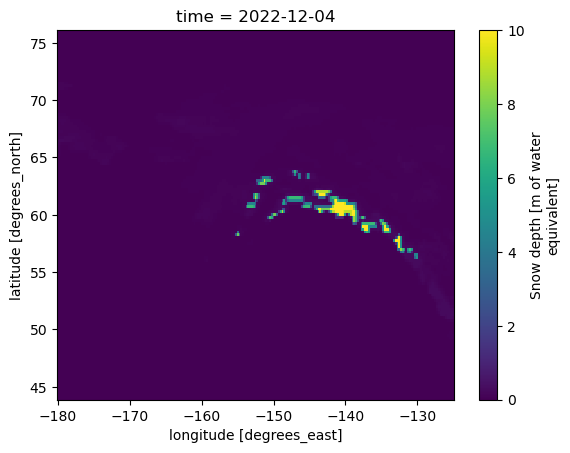

In [33]:
ds["sd"].sel(time=ds.time.values[-1]).plot()

In [44]:
from scipy.ndimage import gaussian_filter

(365, 129, 221)

In [84]:
da2 = ds["sd"].copy(deep=True)
da2.data = gaussian_filter(ds["sd"], sigma=(2, 0, 0))

In [89]:
da2

<xarray.DataArray 'sd' (time: 365, latitude: 129, longitude: 221)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... -125.5 -125.2 -125.0
  * latitude   (latitude) float32 76.0 75.75 75.5 75.25 ... 44.5 44.25 44.0
  * time       (time) datetime64[ns] 2021-12-05 2021-12-06 ... 2022-12-04
Attributes:
    units:          m of water equivalent
    long_name:      Snow depth
    standard_name:  lwe_thickness_of_surface_snow_amount

In [86]:
np.nan, da2.shape)

(365, 129, 221)

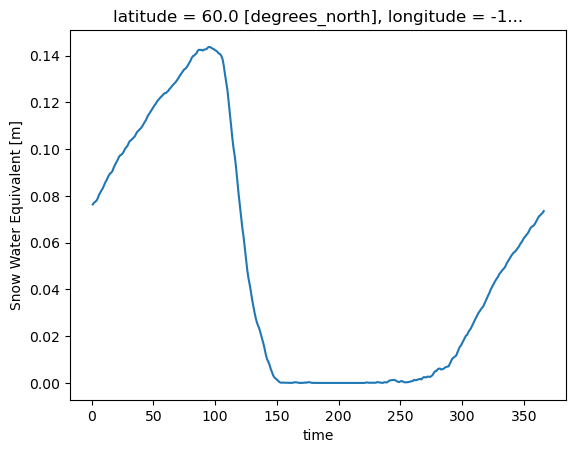

In [42]:
swe_clim_ds["swe"].sel(latitude=60, longitude=140, method="nearest").plot()